In [14]:
# import sys
!{sys.executable} -m pip install sklearn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 31.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 KB 30.1 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=41ad472d33deb6eff4e7b119eba8816cf3c581e47695d122bfc46df7dd5e7696
  Stored in directory: /home/trent/.cache/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [17]:
# Import the required modules
import glob
import sys
import time
import os
from collections import defaultdict
import fdsreader as fds
import matplotlib.pyplot as plt
import numpy as np
from  scipy import interpolate,signal


from scipy.integrate import solve_ivp
from matplotlib import cm

from sklearn.preprocessing import normalize

In [3]:
class windODE:
    def __init__(
            self,
            directory,
            fds_input_location,
            t_span,
    ):
        """

        :param directory: location of the fds output files
        :param fds_input_location: location of the fds input file
        :param t_span: time frame for ODE to run over

        :vars self.sim: fdsreader object
        :vars self.fds_input_location: fds_input_location
        :vars self.t_span: t_span
        :vars self.__directory: directory
        :vars self.__qFiles: list of all plot 3d output files
        :vars self.__timeList: list of all plot 3d time dumps
        :vars self.__voxalSize: resolution of each voxal
        :vars self.__maxVelocity: maximum velocity of any particle in the streamlines
        :vars self.startingpoints: list of all starting points to be used in the ODE

        """

        self.sim = fds.Simulation(directory)
        self.fds_input_location = fds_input_location
        self.t_span = t_span
        self.__directory = directory
        self.__qFiles = glob.glob(directory + "*.q")
        self.__timeList = np.array(self.sim.data_3d.times)
        self.__voxalSize = {}
        self.__maxVelocity = 0.0
        self.__maxRe = 0.0
        self.startingpoints = []
        self.__meshBounds = self.sim.meshes[0]
        self.__meshExtent = self.sim.meshes[0].extent

        self.getVoxalSize()

    def getVoxalSize(self):
        """
        Calculates voxal size
        :return:
        """

        self.__voxalSize["vx"] = (self.__meshExtent.x_end - self.__meshExtent.x_start) / (
                self.__meshBounds.dimension["x"] - 1
        )
        self.__voxalSize["vz"] = (self.__meshExtent.z_end - self.__meshExtent.z_start) / (
                self.__meshBounds.dimension["z"] - 1
        )
        self.__voxalSize["vy"] = (self.__meshExtent.y_end - self.__meshExtent.y_start) / (
                self.__meshBounds.dimension["y"] - 1
        )
        return self

    def getStartingPoints(self):

        """
        Creates a list of points  on the outer most voxals of OBSTS, one point per voxal
        :var X_Min_Value center point of minimum x voxal
        :var X_Max_Value center point of maximum x voxal
        :var Y_Min_Value center point of minimum y voxal
        :var Y_Max_Value center point of maximum y voxal

        :return:
        """
        X_Min_Value = (
                self.__meshExtent.x_start + self.__voxalSize["vx"] / 2.0
        )
        X_Max_Value = (
                self.__meshExtent.x_end - self.__voxalSize["vx"] / 2.0
        )
        Y_Min_Value = (
                self.__meshExtent.y_start + self.__voxalSize["vy"] / 2.0
        )
        Y_Max_Value = (
                self.__meshExtent.y_end - self.__voxalSize["vy"] / 2.0
        )
        with open(self.fds_input_location) as f:
            lines = f.readlines()

        lineCounter = 0
        while lineCounter < len(lines):
            current_line = lines[lineCounter]
            if current_line == "\n":
                lineCounter += 1
                continue
            while "/" not in lines[lineCounter]:
                lineCounter += 1
                current_line = current_line + lines[lineCounter]

            lineCounter += 1
            if "&OBST" not in current_line:
                continue
            mesh_line = current_line.replace("/", "").replace("\n", "")
            XB = [float(point) for point in mesh_line.split("XB=")[1].split(",")[:6]]

            if XB[0] <= X_Min_Value <= XB[1]:
                self.startingPointsRibbon(
                    [XB[0], XB[2], XB[5] + self.__voxalSize["vz"]],
                    [XB[0], XB[3], XB[5] + self.__voxalSize["vz"]],
                    int((XB[1] - XB[0]) / self.__voxalSize["vx"]),
                )

            if XB[0] <= X_Max_Value <= XB[1]:
                self.startingPointsRibbon(
                    [XB[1], XB[2], XB[5] + self.__voxalSize["vz"]],
                    [XB[1], XB[3], XB[5] + self.__voxalSize["vz"]],
                    int((XB[1] - XB[0]) / self.__voxalSize["vx"]),
                )
            if XB[2] <= Y_Min_Value <= XB[3]:
                self.startingPointsRibbon(
                    [XB[0], XB[2], XB[5] + self.__voxalSize["vz"]],
                    [XB[1], XB[2], XB[5] + self.__voxalSize["vz"]],
                    int((XB[3] - XB[2]) / self.__voxalSize["vy"]),
                )
            if XB[2] <= Y_Max_Value <= XB[3]:
                self.startingPointsRibbon(
                    [XB[0], XB[3], XB[5] + self.__voxalSize["vz"]],
                    [XB[1], XB[3], XB[5] + self.__voxalSize["vz"]],
                    int((XB[3] - XB[2]) / self.__voxalSize["vy"]),
                )

        return self

    def filterOutStreamsByLength(self):
        """
        This function removes all streamlines that total distance traveled is below a desired length.
        :return:
        """
        self.filteredTImeResults = {}

        self.distanceofWindStreams_index = defaultdict(lambda: [])
        allData = self.timeReasults
        for time in allData.keys():

            data = allData[time]
            numberofWindstreams = len(data)
            lengthofWindStreams = [len(x["y"][0]) for x in data]
            print(numberofWindstreams)
            print(lengthofWindStreams)
            for i in range(numberofWindstreams):
                distanceofWindStream = 0
                for j in range(1, len(data[i]["y"][0])):
                    point1 = np.array(
                        (
                            data[i]["y"][0][j - 1],
                            data[i]["y"][1][j - 1],
                            data[i]["y"][2][j - 1],
                        )
                    )
                    point2 = np.array(
                        (data[i]["y"][0][j], data[i]["y"][1][j], data[i]["y"][2][j])
                    )
                    p1_p2_distance = np.linalg.norm(point1 - point2)
                    distanceofWindStream += p1_p2_distance

                if distanceofWindStream > np.min(list(self.__voxalSize.values())) * 2.0:
                    self.distanceofWindStreams_index[time].append(i)

    def startingPointsRibbon(self, starting_pont, ending_point, number_of_points):
        x_ = np.linspace(starting_pont[0], ending_point[0], number_of_points)
        y_ = np.linspace(starting_pont[1], ending_point[1], number_of_points)
        z_ = np.linspace(starting_pont[2], ending_point[2], number_of_points)
        points = np.stack((x_.flatten(), y_.flatten(), z_.flatten()), axis=1)

        self.startingpoints.extend(points)
        return self

    def runODE(self, timedependent=True):
        self.timeReasults = {}
        for t_start in self.__timeList:
            if t_start > self.t_span[1] or t_start < self.t_span[0]:
                break

            closest_timeStep = min(self.__timeList, key=lambda x: abs(x - t_start))
            counter = np.where(self.__timeList == closest_timeStep)[0][0]
            all_results = []
            for startCounter in range(len(self.startingpoints)):

                y0 = self.startingpoints[startCounter]
                t_span = [
                    min(self.__timeList[counter:]),
                    max(self.__timeList[counter:]),
                ]
                # rtol=1E-4, atol=1E-6,
                result_solve_ivp = solve_ivp(
                    self.get_velocity, t_span, y0, args=[t_span[0], timedependent]
                )
                result_with_velocity = self.addVelocity(result_solve_ivp)
                current_result_max_vel = np.max(result_with_velocity["velocity"])
                if self.__maxVelocity < current_result_max_vel:
                    print(
                        f"new max Velocity {current_result_max_vel} changed from {self.__maxVelocity}"
                    )
                    self.__maxVelocity = current_result_max_vel
                result_with_re = self.addReynoldsNumber(result_with_velocity)

                current_result_max_re = np.max(result_with_velocity["re"])
                if self.__maxRe < current_result_max_re:
                    print(
                        f"new max Velocity {current_result_max_re} changed from {self.__maxRe}"
                    )
                    self.__maxRe = current_result_max_re
                all_results.append(result_with_re)
            self.timeReasults[t_start] = all_results
        return self

    def write2bin(self, desired_directory, file_name_prefix):
        fileName = os.path.join(desired_directory, file_name_prefix)
        allData = self.timeReasults
        maxVel = self.__maxVelocity
        print(f"Max {maxVel}")
        for time in allData.keys():
            data = allData[time]
            numberofWindstreams = len(data)
            lengthofWindStreams = [len(x["y"][0]) for x in data]
            print(numberofWindstreams)
            print(lengthofWindStreams)
            time_string = f"{time}".split(".")[1]
            with open(f"{fileName}_{int(time)}_{time_string}.binwind", "wb") as outfile:

                np.ndarray.tofile(np.array([maxVel], dtype=np.float32), outfile)
                np.ndarray.tofile(np.array([numberofWindstreams], dtype=int), outfile)
                np.ndarray.tofile(np.array(lengthofWindStreams, dtype=int), outfile)

                for i in range(numberofWindstreams):
                    currentStream = []
                    for j in range(len(data[i]["y"][0])):
                        currentStream.append(
                            [
                                data[i]["t"][j],
                                data[i]["velocity"][j],
                                data[i]["y"][0][j],
                                data[i]["y"][1][j],
                                data[i]["y"][2][j],
                            ]
                        )

                    np.ndarray.tofile(
                        np.array(currentStream, dtype=np.float32), outfile
                    )
                print(fileName, "saved")
        return self

    def get_velocity(self, t, x, t_0, timedependent):

        t = t if timedependent else t_0
        closest_timeStep = min(self.__timeList, key=lambda x: abs(x - t))
        counter = np.where(self.__timeList == closest_timeStep)[0][0]
        plt_3d_data = self.sim.data_3d[int(counter)]

        mesh = self.sim.meshes[0]
        # Select a quantity
        uvel_idx = plt_3d_data.get_quantity_index("U-VEL")
        vvel_idx = plt_3d_data.get_quantity_index("V-VEL")
        wvel_idx = plt_3d_data.get_quantity_index("W-VEL")
        index_values = self.get_index_values(x)
        u_vel_data = plt_3d_data[mesh].data[:, :, :, uvel_idx]
        u_velocity = u_vel_data[index_values[0], index_values[1], index_values[2]]
        v_vel_data = plt_3d_data[mesh].data[:, :, :, vvel_idx]
        v_velocity = v_vel_data[index_values[0], index_values[1], index_values[2]]
        w_vel_data = plt_3d_data[mesh].data[:, :, :, wvel_idx]
        w_velocity = w_vel_data[index_values[0], index_values[1], index_values[2]]

        return np.array([u_velocity, v_velocity, w_velocity])

    def get_index_values(self, x):
        x_index = (x[0] - self.__meshExtent.x_start) / self.__voxalSize["vx"]
        if 0 > x_index or x_index > self.__meshBounds.dimension["x"]:
            return np.array([0, 0, 0], dtype=int)
        y_index = (x[1] - self.__meshExtent.y_start) / self.__voxalSize["vy"]
        if 0 > y_index or y_index > self.__meshBounds.dimension["y"]:
            return np.array([0, 0, 0], dtype=int)
        z_index = (x[2] - self.__meshExtent.z_start) / self.__voxalSize["vz"]
        if 0 > z_index or z_index > self.__meshBounds.dimension["z"]:
            return np.array([0, 0, 0], dtype=int)
        return np.array([x_index, y_index, z_index], dtype=int)

    def addReynoldsNumber(self, oneDataSet):
        """

        :param oneDataSet:
        :return: same dataset with added velocity information
        """

        allRe = []  # all particles start at 0 velocity

        allTimes = oneDataSet["t"]
        allPositions = oneDataSet["y"]
        for i in range(len(allPositions[0])):
            currentPosition = np.array(
                [allPositions[0][i], allPositions[1][i], allPositions[2][i]]
            )

            currentTime = allTimes[i]
            allRe.append(self.getRaynoldsNumber(currentPosition, currentTime))

        oneDataSet["re"] = np.array(allRe)
        return oneDataSet

    def addVelocity(self, oneDataSet):
        """

        :param oneDataSet:
        :return: same dataset with added velocity information
        """

        allSpeeds = [0.0]  # all particles start at 0 velocity

        allTimes = oneDataSet["t"]
        allPositions = oneDataSet["y"]
        previousPosition = np.array(
            [allPositions[0][0], allPositions[1][0], allPositions[2][0]]
        )
        for i in range(1, len(allPositions[0])):
            currentPosition = np.array(
                [allPositions[0][i], allPositions[1][i], allPositions[2][i]]
            )

            deltaTime = allTimes[i] - allTimes[i - 1]
            squared_dist = np.sum((currentPosition - previousPosition) ** 2, axis=0)
            dist = np.sqrt(squared_dist)

            speed = dist / deltaTime
            allSpeeds.append(speed)
            previousPosition = currentPosition

        oneDataSet["velocity"] = np.array(allSpeeds)
        return oneDataSet

    def drawPlot(self):

        allData = self.timeReasults
        for time in self.distanceofWindStreams_index.keys():
            data = allData[time]

            fig = plt.figure(figsize=(8, 6))
            allRE=[]
            ax = fig.add_subplot(1, 1, 1, projection="3d")
            for i in self.distanceofWindStreams_index[time]:
                x = data[i]["y"][0][:]
                y = data[i]["y"][1][:]
                z = data[i]["y"][2][:]
                re = data[i]["re"][:]
                allRE.append(re)
                if ((self.__maxRe-np.max(re)) / self.__maxRe)>0.33:
                    ax.plot(x, y, z, c=cm.binary(1))
                    continue
                ax.plot(x, y, z,  c=cm.viridis((((self.__maxRe-np.max(re)) / self.__maxRe)+.1)/0.43))
            plt.show()
            allRe= np.hstack(allRE)
            print(f"Re Values min  {np.min(allRe)}  max  {np.max(allRe)} std Dev {np.std(allRe)}  mean {np.mean(allRe)}")



    def getRaynoldsMatrix(self,t):
        closest_timeStep = min(self.__timeList, key=lambda x: abs(x - t))
        counter = np.where(self.__timeList == closest_timeStep)[0][0]
        plt_3d_data = self.sim.data_3d[int(counter)]

        mesh = self.sim.meshes[0]
        # Select a quantity
        try:
            dxeta_idx = plt_3d_data.get_quantity_index("dx/eta")
        except:
            return [0]

        re_data = plt_3d_data[mesh].data[:, :, :, dxeta_idx]

        return re_data

    def getRaynoldsNumber(self, x, t):
        closest_timeStep = min(self.__timeList, key=lambda x: abs(x - t))
        counter = np.where(self.__timeList == closest_timeStep)[0][0]
        plt_3d_data = self.sim.data_3d[int(counter)]

        mesh = self.sim.meshes[0]
        # Select a quantity
        try:
            dxeta_idx = plt_3d_data.get_quantity_index("dx/eta")
        except:
            return [0]
        index_values = self.get_index_values(x)

        re_data = plt_3d_data[mesh].data[:, :, :, dxeta_idx]
        re_value = re_data[index_values[0], index_values[1], index_values[2]]

        return re_value

    def getDataFromTime(self,t):
        if t in self.timeReasults.keys():
            return self.timeReasults[t]
        return []
    def getMaxRE(self):
        return self.__maxRe


In [4]:


fds_loc = "/home/trent/fds3/fds/trails.fds"
dir = "/home/trent/fds3/"
fds_loc = "/home/trent/Trunk/Trunk/Trunk.fds"
dir = "/home/trent/Trunk/TempCheck"
# fds_loc = "E:\Trunk\Trunk\Trunk\Trunk.fds"
# dir = "E:\Trunk\Trunk\\temp\\"

t_span = [0, 2]
start_time = time.perf_counter()
app = windODE(dir, fds_loc, t_span)
app.getStartingPoints()
#app.startingPointsRibbon([19,1,	3.5],[ 19,	19,	3.5],40)
app.runODE(timedependent=True)
app.filterOutStreamsByLength()
# app.write2bin("data","temp")
print(f"Total Time {time.perf_counter()-start_time:0.4f}")
# app.drawPlot()




new max Velocity 0.6542505087048294 changed from 0.0
new max Velocity 526.018798828125 changed from 0.0
new max Velocity 0.6808571618539547 changed from 0.6542505087048294
new max Velocity 547.1720581054688 changed from 526.018798828125
new max Velocity 784.5548706054688 changed from 547.1720581054688
new max Velocity 821.87841796875 changed from 784.5548706054688
new max Velocity 7.469975718626486 changed from 0.6808571618539547
new max Velocity 892.003173828125 changed from 821.87841796875
new max Velocity 924.2844848632812 changed from 892.003173828125
new max Velocity 1039.48095703125 changed from 924.2844848632812
new max Velocity 1072.4791259765625 changed from 1039.48095703125
new max Velocity 1178.4959716796875 changed from 1072.4791259765625
new max Velocity 1347.5166015625 changed from 1178.4959716796875
new max Velocity 1615.1923828125 changed from 1347.5166015625
new max Velocity 8.068061527533162 changed from 7.469975718626486
new max Velocity 8.14671524965944 changed from

(101, 101, 101)
173840 <class 'numpy.ndarray'> [  0   0   0 ... 100 100 100]
173840 <class 'numpy.ndarray'> [ 1  1  1 ... 99 99 99]
173840 <class 'numpy.ndarray'> [12 13 14 ... 54 60 76]
[1.96165806e-03 1.53494233e-03 9.16615951e-04 5.42798866e-04
 3.98797001e-04 3.19449035e-04 2.27758051e-04 1.40181407e-04
 3.40902374e-05 3.82045764e-06] [164.47067108 164.47067108 164.47067108 164.47067108 164.47067108
 164.47067108 164.47067108 164.47067108 164.47067108 164.47067108] [ 200.00483704  364.47550812  528.9461792   693.41685028  857.88752136
 1022.35819244 1186.82886353 1351.29953461 1515.77020569 1680.24087677
 1844.71154785]


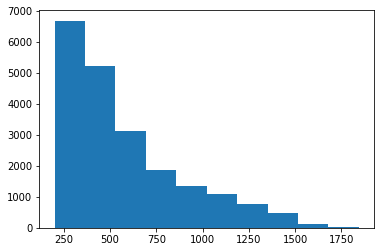

In [39]:
testData = app.getRaynoldsMatrix(0.51)
test =signal.argrelextrema(testData,np.greater,axis=1)
print(np.array(testData).shape)
for i in test:
    print(len(i), type(i), i)




# Creating color map
my_cmap = plt.get_cmap('hsv')

x = test[0][:]
y = test[1][:]
z = test[2][:]

# Creating plot
cvals = []
x_f = []
y_f=[]
z_f = []
for i in range(len(x)):
    if testData[x[i]][y[i]][z[i]]<200:
        continue
    x_f.append(x[i])
    y_f.append(y[i])
    z_f.append(z[i])
    cvals.append(testData[x[i]][y[i]][z[i]])
hist, bin_edges = np.histogram(cvals, density=True)
print(hist,np.diff(bin_edges), bin_edges)
plt.hist(cvals, bins=10)
plt.show()

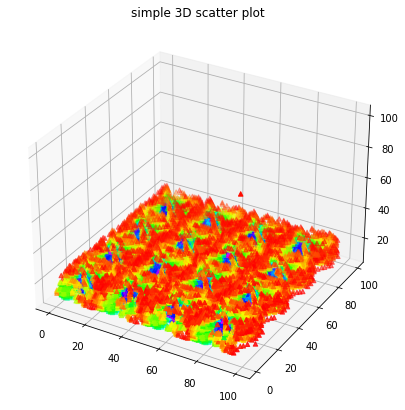

In [41]:

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(x_f, y_f, z_f,
                    c = cvals,
                    cmap = my_cmap,
                    marker ='^')
plt.title("simple 3D scatter plot")

# show plot
plt.show()

### The Reynolds number is defined as

    Re = uL/ν = ρuL/μ 

where:

    ρ is the density of the fluid (SI units: kg/m3)
    u is the flow speed (m/s)
    L is a characteristic linear dimension (m) (see the below sections of this article for examples)
    μ is the dynamic viscosity of the fluid (Pa·s or N·s/m2 or kg/(m·s))
    ν is the kinematic viscosity of the fluid (m2/s).

### The Dynamic viscocity coefficient is defined as

    μ = μo*(a/b)*(T/To)3/2

    a = 0.555To + C
    b = 0.555T + C

where

    μ  = viscosity in centipoise at input temperature T    
    μ0 = reference viscosity in centipoise at reference temperature To 0.01827
    T   = input temperature in degrees Rankine
    T0 = reference temperature in degrees Rankine 524.07
    C  = Sutherland's constant  = 120